# Causal Inference with CEM and Weighted Regression

In [51]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
from datetime import datetime, timedelta

import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from cem.match import match
from cem.coarsen import coarsen
from cem.imbalance import L1
from pymongo.mongo_client import MongoClient
from pymongo.server_api import ServerApi

In [52]:
uri = os.environ["MONGODB_URI"]
client = MongoClient(uri, server_api=ServerApi("1"))
client.admin.command("ping")
db = client["real-estate"]
collection = db["listings"]

In [53]:
since = datetime.now() - timedelta(days=30)

pipeline = [
        {
            "$match": {"rental": True, "datetime": {"$gte": since}, "bed": {"$lte": 4}},
        },
    ]

results = collection.aggregate(pipeline)

df = pd.DataFrame.from_records(results).set_index("_id")
df.head()

,datetime,provider,rental,price,address,suburb,state,postcode,council,bed,bath,parking,area,dwelling,version
_id,,,,,,,,,,,,,,,
listing-16678011,2023-09-30,domain,True,600,"Tennyson Avenue, Plympton Park, Adelaide, City...",plympton park,sa,5038,city of marion,3,1,2,NaN,house,0.1.0
listing-16677966,2023-09-30,domain,True,595,"Waikiki Court, West Lakes, Adelaide, City of C...",west lakes,sa,5021,city of charles sturt,3,1,2,NaN,house,0.1.0
listing-16675969,2023-09-30,domain,True,650,"Bimini Crescent, Mawson Lakes, Adelaide, City ...",mawson lakes,sa,5095,city of salisbury,3,2,1,NaN,townhouse,0.1.0
listing-16677999,2023-09-30,domain,True,480,"Pierson Street, Campbelltown City Council, Ade...",hectorville,sa,5073,city of campbelltown,3,1,2,NaN,house,0.1.0
listing-16677277,2023-09-30,domain,True,610,"Grote Street, Adelaide, Adelaide City Council,...",adelaide,sa,5000,corporation of the city of adelaide,2,1,0,NaN,apartment / unit / flat,0.1.0


In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 422 entries, listing-16678011 to listing-16693972
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  422 non-null    datetime64[ns]
 1   provider  422 non-null    object        
 2   rental    422 non-null    bool          
 3   price     422 non-null    int64         
 4   address   422 non-null    object        
 5   suburb    422 non-null    object        
 6   state     422 non-null    object        
 7   postcode  422 non-null    object        
 8   council   422 non-null    object        
 9   bed       422 non-null    int64         
 10  bath      422 non-null    int64         
 11  parking   422 non-null    int64         
 12  area      49 non-null     float64       
 13  dwelling  422 non-null    object        
 14  version   422 non-null    object        
dtypes: bool(1), datetime64[ns](1), float64(1), int64(4), object(8)
memory usage: 49.9+ KB

In [55]:
df.describe()

,datetime,price,bed,bath,parking,area
count,422,422.000000,422.000000,422.000000,422.000000,49.000000
mean,2023-10-04 22:34:41.516587776,565.308057,2.786730,1.466825,1.694313,459.979592
min,2023-09-30 00:00:00,195.000000,1.000000,1.000000,0.000000,71.000000
25%,2023-10-04 00:00:00,460.000000,2.000000,1.000000,1.000000,320.000000
50%,2023-10-04 00:00:00,547.500000,3.000000,1.000000,2.000000,419.000000
75%,2023-10-09 00:00:00,620.000000,3.000000,2.000000,2.000000,637.000000
max,2023-10-11 00:00:00,1800.000000,4.000000,3.000000,8.000000,990.000000
std,NaN,182.150716,0.756297,0.549315,1.146684,216.709626


In [56]:
df[["bed", "bath", "parking"]].cov()

,bed,bath,parking
bed,0.571985,0.182932,0.407335
bath,0.182932,0.301747,0.112162
parking,0.407335,0.112162,1.314884


In [57]:
df["council"].value_counts()

council
city of port adelaide enfield                             44
city of playford                                          44
city of charles sturt                                     43
corporation of the city of adelaide                       35
city of salisbury                                         34
city of marion                                            29
corporation of the city of unley                          23
city of onkaparinga                                       22
city of norwood payneham & st peters                      20
city of campbelltown                                      17
city of west torrens                                      16
city of tea tree gully                                    14
city of burnside                                          13
city of holdfast bay                                      13
mount barker district council                             11
city of prospect & city of port adelaide enfield          11
city of mitcham 

In [58]:
councils = {
    "city of playford": "north",
    "city of port adelaide enfield": "north",
    "city of charles sturt": "west",
    "city of salisbury": "north",
    "corporation of the city of adelaide": "inner",
    "corporation of the city of unley": "inner",
    "city of marion": "south",
    "city of onkaparinga": "south",
    "city of campelltown": "east",
    "city of norwood payneham & st peters": "inner",
    "city of west torrens": "west",
    "city of tea tree gully": "north",
    "city of burnside": "east",
    "city of holdfast bay": "west",
    "mount barker district council": "hills",
    "city of prospect & city of port adelaide enfield": "north",
    "corporation of the town of walkerville": "inner",
    "city of mitcham": "south",
    "city of prospect": "inner",
    "adelaide hills council": "hills",
    "town of gawler": "outer",
    "the barossa council": "outer",
    "city of port adelaide enfield & city of tea tree gully": "north"
}

In [59]:
y = df["price"]
X = df.drop(columns="price")[["bed", "bath", "parking", "council", "dwelling", "area"]]

In [60]:
# no matching
L1(X, "bed")
# very imbalanced

/Users/ljbails/Library/Caches/pypoetry/virtualenvs/real-estate-53Vs7j0A-py3.9/lib/python3.9/site-packages/cem/imbalance.py:23: RuntimeWarning: divide by zero encountered in divide
  return np.sum(np.abs(tensor_a / np.sum(tensor_a) - tensor_b / np.sum(tensor_b))) / 2
/Users/ljbails/Library/Caches/pypoetry/virtualenvs/real-estate-53Vs7j0A-py3.9/lib/python3.9/site-packages/cem/imbalance.py:23: RuntimeWarning: invalid value encountered in divide
  return np.sum(np.abs(tensor_a / np.sum(tensor_a) - tensor_b / np.sum(tensor_b))) / 2


,bed_level_a,bed_level_b,imbalance
0,1,2,NaN
1,1,3,NaN
2,1,4,NaN
3,2,3,1.0
4,2,4,1.0
5,3,4,1.0


In [61]:
# exact matching
# throw away examples from strata (defined by council, dwelling, bath, parking and area) that do not contain all levels of the treatment (number of beds)
weights = match(X, "bed")

print(f"{(weights > 0).sum()} observations remain. Threw away {(weights == 0).sum()}")

L1(X, "bed", weights)
# no examples left..

0 observations remain. Threw away 422


/Users/ljbails/Library/Caches/pypoetry/virtualenvs/real-estate-53Vs7j0A-py3.9/lib/python3.9/site-packages/cem/match.py:30: UserWarning: No strata had all levels of the treatment variable. All weights will be zero. This usually happens when a continuous variable (including the treatment variable) is not coarsened.
  warnings.warn(
/Users/ljbails/Library/Caches/pypoetry/virtualenvs/real-estate-53Vs7j0A-py3.9/lib/python3.9/site-packages/cem/imbalance.py:23: RuntimeWarning: divide by zero encountered in divide
  return np.sum(np.abs(tensor_a / np.sum(tensor_a) - tensor_b / np.sum(tensor_b))) / 2
/Users/ljbails/Library/Caches/pypoetry/virtualenvs/real-estate-53Vs7j0A-py3.9/lib/python3.9/site-packages/cem/imbalance.py:23: RuntimeWarning: invalid value encountered in divide
  return np.sum(np.abs(tensor_a / np.sum(tensor_a) - tensor_b / np.sum(tensor_b))) / 2


,bed_level_a,bed_level_b,imbalance
0,1,2,NaN
1,1,3,NaN
2,1,4,NaN
3,2,3,NaN
4,2,4,NaN
5,3,4,NaN


In [62]:
# coarsened exact matching
# throw away examples from strata (defined by COARSENED council, dwelling, bath and parking) that do not contain all levels of the treatment (number of beds)
X_coarse = X.copy()

X_coarse["council"] = X_coarse["council"].map(councils)  # north, south, east, west, inner, hills, outer
X_coarse["parking"] = X_coarse["parking"] > 0  # yes or no
X_coarse["bath"] = pd.cut(X_coarse["bath"], bins=[-1, 1, 2, 100])  # 1, 2, 3+
X_coarse["area"] = pd.cut(X_coarse["area"], bins=[-1, 200, 400, 800, 10000]).cat.add_categories("missing").fillna("missing")

weights = match(X_coarse, "bed")
weights = weights[X.index]  # not necessary, but it supresses that warning

print(f"{(weights > 0).sum()} observations remain. Threw away {(weights == 0).sum()}")

L1(X_coarse, "bed", weights)

37 observations remain. Threw away 385


,bed_level_a,bed_level_b,imbalance
0,1,2,0.0
1,1,3,0.0
2,1,4,0.0
3,2,3,0.0
4,2,4,0.0
5,3,4,0.0


In [63]:
X_coarse[weights > 0].sort_values(["council", "dwelling", "area", "bath", "parking", "bed"]).head(20)

,bed,bath,parking,council,dwelling,area
_id,,,,,,
listing-16680778,1,"(-1, 1]",True,north,house,missing
listing-15250606,2,"(-1, 1]",True,north,house,missing
listing-16681458,2,"(-1, 1]",True,north,house,missing
listing-16680748,2,"(-1, 1]",True,north,house,missing
listing-16691377,2,"(-1, 1]",True,north,house,missing
listing-16694512,2,"(-1, 1]",True,north,house,missing
listing-16675492,3,"(-1, 1]",True,north,house,missing
listing-14699350,3,"(-1, 1]",True,north,house,missing
listing-15731201,3,"(-1, 1]",True,north,house,missing


In [64]:
print(X_coarse[weights > 0]["dwelling"].value_counts())
print(X_coarse[weights > 0]["council"].value_counts())
print(X_coarse[weights > 0]["parking"].value_counts())
print(X_coarse[weights > 0]["bath"].value_counts())
print(X_coarse[weights > 0]["area"].value_counts())

dwelling
house    37
Name: count, dtype: int64
council
north    37
Name: count, dtype: int64
parking
True    37
Name: count, dtype: int64
bath
(-1, 1]     37
(1, 2]       0
(2, 100]     0
Name: count, dtype: int64
area
missing         37
(-1, 200]        0
(200, 400]       0
(400, 800]       0
(800, 10000]     0
Name: count, dtype: int64


In [65]:
# after coarsened matching, there is very little imbalance, so i'm happy not to control for council and dwelling
model = sm.WLS(y, sm.add_constant(X[["bed"]]), weights=weights, hasconst=True)
model.exog_names[:] = ["constant", "bed"]
results = model.fit()

In [66]:
summary = results.summary()
summary

/Users/ljbails/Library/Caches/pypoetry/virtualenvs/real-estate-53Vs7j0A-py3.9/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:807: RuntimeWarning: divide by zero encountered in log
  llf += 0.5 * np.sum(np.log(self.weights))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.145
Model:                            WLS   Adj. R-squared:                  0.143
Method:                 Least Squares   F-statistic:                     71.37
Date:                Wed, 11 Oct 2023   Prob (F-statistic):           4.90e-16
Time:                        13:52:32   Log-Likelihood:                   -inf
No. Observations:                 422   AIC:                               inf
Df Residuals:                     420   BIC:                               inf
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
constant     266.2500     27.448      9.700      0.000     212.297     320.203
bed           78.7266      9.319      8.448      0.000      60.409      97.044
==============================================================================
Omnibus:                      672.013   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           390624.699
Skew:                           8.468   Prob(JB):                         0.00
Kurtosis:                     151.084   Cond. No.                         17.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [67]:
print(summary.as_html())

<table class="simpletable">
<caption>WLS Regression Results</caption>
<tr>
  <th>Dep. Variable:</th>          <td>price</td>      <th>  R-squared:         </th> <td>   0.145</td>
</tr>
<tr>
  <th>Model:</th>                   <td>WLS</td>       <th>  Adj. R-squared:    </th> <td>   0.143</td>
</tr>
<tr>
  <th>Method:</th>             <td>Least Squares</td>  <th>  F-statistic:       </th> <td>   71.37</td>
</tr>
<tr>
  <th>Date:</th>             <td>Wed, 11 Oct 2023</td> <th>  Prob (F-statistic):</th> <td>4.90e-16</td>
</tr>
<tr>
  <th>Time:</th>                 <td>13:52:32</td>     <th>  Log-Likelihood:    </th> <td>    -inf</td>
</tr>
<tr>
  <th>No. Observations:</th>      <td>   422</td>      <th>  AIC:               </th> <td>     inf</td>
</tr>
<tr>
  <th>Df Residuals:</th>          <td>   420</td>      <th>  BIC:               </th> <td>     inf</td>
</tr>
<tr>
  <th>Df Model:</th>              <td>     1</td>      <th>                     </th>     <td> </td>   
</tr>
<tr>
  <th

In [68]:
# analysis of residuals
residual = results.resid
predicted = results.fittedvalues

<Axes: xlabel='bed', ylabel='None'>

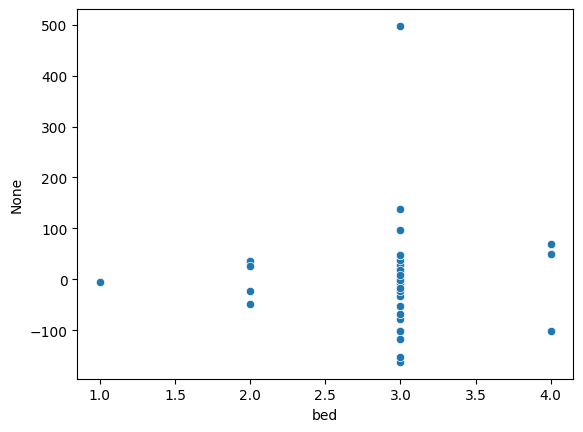

In [69]:
sns.scatterplot(x=X[weights > 0]['bed'], y=results.resid[weights > 0])

In [70]:
# possibly the ignorability assumption is not satisfied
# i.e. there are other confounders that should be taken into account